In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import matplotlib as plt

#NLP
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
#df_JWC=pd.read_csv("JWC_alltweets.csv")
#Using non-retweets file for Topic Modeling
df_JWC=pd.read_csv("JWC_alltweets1.csv")

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
df_JWC

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Datetime,Tweet Id,Text,Username,User Location,Reply Count,Retweet Count,Like Count,Quote Count,Date,compound,Month,Clean Tweet
0,2021-05-19 03:03:23+00:00,1.394850e+18,Water issues in the city again? SMH\n\n#Jacks...,FNULNU1,NaN,0,0,0,0,5/19/2021,-0.4648,5,water issues in the city again smh jacksonwate...
1,2021-04-24 02:14:03+00:00,1.385780e+18,#JacksonWaterCrisis https://t.co/OFuCz2zYa9,Backstorymom1,NaN,0,0,0,0,4/24/2021,0.0000,4,jacksonwatercrisis
2,2021-04-21 12:26:37+00:00,1.384850e+18,Anyone with mobile video of the #jacksonwaterc...,nicolahann,"New York, NY",0,0,0,0,4/21/2021,0.3400,4,anyone with mobile video of the jacksonwatercr...
3,2021-04-07 21:13:26+00:00,1.379910e+18,#FlintWaterCrisis #JacksonWaterCrisis https://...,JalenRoseBat,Imported from Detroit,0,0,0,0,4/7/2021,0.0000,4,flintwatercrisis jacksonwatercrisis
4,2021-03-22 23:57:03+00:00,1.374150e+18,Jackson Mississippi's Water Crisis is Rooted i...,ru2inept,The Twilight Zone,0,3,0,0,3/22/2021,-0.8481,3,jackson mississippi s water crisis is rooted i...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2809,2021-03-02 21:29:35+00:00,1.366860e+18,Governor: We’ll have to have a serious convers...,keeganfoxx,"Jackson, MS",0,1,1,0,3/2/2021,0.5413,3,governor we ll have to have a serious conversa...
2810,2021-02-28 17:40:09+00:00,1.366080e+18,@HindsEOC You nincompoops should fix the broke...,AlanBuckles,NaN,0,0,0,0,2/28/2021,-0.2124,2,hindseoc you nincompoops should fix the broke...
2811,2021-02-25 00:17:15+00:00,1.364730e+18,@kaylahazel_ our north been complaining about ...,GaredQuinn,"Jackson, MS",0,0,0,0,2/25/2021,0.3584,2,kaylahazel our north been complaining about w...
2812,2021-02-24 13:52:51+00:00,1.364570e+18,@jordanrhillman Exactly. He’ll take credit for...,FBrownWilliams,"Jackson, MS",0,0,0,0,2/24/2021,-0.0258,2,jordanrhillman exactly he ll take credit for ...


In [5]:
#Preprocessing tweets- Cleaning, Tokenizing

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text=re.sub('[^A-Za-z0-9]+', ' ', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df_JWC['Clean Tweet']=df_JWC['Text'].apply(lambda x:clean_text(x))


def remove_stopwords(x):
    stopword=stopwords.words('english')
    stopword.append("amp")
    stopword.append("t")
    stopword.append("co")
    
   
    return [y for y in x if y not in stopword]


df_JWC['word list']=df_JWC['Clean Tweet'].apply(lambda x:str(x).split())
df_JWC['word list']=df_JWC['word list'].apply(lambda x:remove_stopwords(x))

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
<ipython-input-5-7ecc77be3e2c>:5: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text)
<ipython-input-5-7ecc77be3e2c>:6: DeprecationWarning: invalid escape sequence \S
  text = re.sub('https?://\S+|www\.\S+', '', text)
<ipython-input-5-7ecc77be3e2c>:10: De

In [6]:
#Lemmatization
# Make tokens a string again
import string
nlp = spacy.load('en_core_web_sm')
# import en_core_web_lg
# nlp = en_core_web_lg.load()

df_JWC['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df_JWC['word list']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df_JWC['lemmas'] = df_JWC['tokens_back_to_text'].apply(get_lemmas)


# Make lemmas a string again
df_JWC['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df_JWC['lemmas']]

# Tokenizer function
def tokenize(text):

    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df_JWC['lemma_tokens'] = df_JWC['lemmas_back_to_text'].apply(tokenize)



C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:38: DeprecationWarning: invalid escape sequence \w
<>:39: DeprecationWarning: invalid escape sequence \$
<>:38: DeprecationWarning: invalid escape sequence \w
<>:39: DeprecationWarning: invalid escape sequence \$
<ipython-input-6-0e7720cc207a>:38: DeprecationWarning: invalid escape sequence \w
  tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
<ipython-input-6-0e7720cc207a>:39: DeprecationWarning: invalid escape sequence \$
  tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $


In [7]:
def remove_stopwords_lemma(x):
    stopword=stopwords.words('english')
    stopword.append("amp")
    stopword.append("t")
    stopword.append("co")
    stopword.append('water')
    stopword.append('crisis')
    stopword.append('jackson')
    stopword.append('mississippi')
    stopword.append('jxnneedswater')
    stopword.append('jacksonwatercrisis')
    stopword.append('ms')
    stopword.append('city')
    stopword.append('state')
    stopword.append('problem')
   
    return [y for y in x if y not in stopword]

df_JWC['lemma_tokens_remstop']=df_JWC['lemma_tokens'].apply(lambda x:remove_stopwords_lemma(x))

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
df_JWC['lemma_tokens_remstop']

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0                                            [issue, smh]
1                                                      []
2            [mobile, video, reach, mignonn, cbsnew, com]
3                                      [flintwatercrisis]
4                     [root, racism, youtube, statuscoup]
                              ...                        
2809    [governor, conversation, long, term, intereste...
2810    [hindseoc, nincompoop, fix, broken, line, plan...
2811    [kaylahazel, north, complain, house, stay, north]
2812    [jordanrhillman, exactly, credit, fixing, exis...
2813                  [thank, tell, brush, tooth, noodle]
Name: lemma_tokens_remstop, Length: 2814, dtype: object

In [42]:
#Topic Modeling using LDA-- cReating a base LDA model(do lemmatization first?)

# Create a id2word dictionary
id2word = Dictionary(df_JWC['lemma_tokens'])
print(len(id2word))

# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df_JWC['lemma_tokens']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=5)
# base_model = LdaMulticore(corpus=corpus,
# id2word=id2word,
# chunksize=100000,
# num_topics=6,
# passes=20,
# workers=12,
# iterations=1000
# )
    
    
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5395
2416
------ Topic 0 ------
water jackson crisis mississippi city week infrastructure resident problem storm

------ Topic 1 ------
water jackson mississippi crisis outage resident month city struggle news

------ Topic 2 ------
water jackson crisis mississippi problem week ms state help city

------ Topic 3 ------
water jackson crisis problem mississippi ms jacksonwatercrisis help infrastructure city



In [43]:
#Visualizing topic model- for 5 topics

import pyLDAvis
import pyLDAvis.gensim_models
#import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(base_model, corpus, dictionary=base_model.id2word)
vis

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.006362  0.017602       1        1  40.808501
0      0.056344  0.069009       2        1  25.852114
1     -0.105151  0.002195       3        1  18.450203
3      0.042445 -0.088806       4        1  14.889182, topic_info=          Term         Freq        Total Category  logprob  loglift
797     outage   198.000000   198.000000  Default  30.0000  30.0000
47    struggle   112.000000   112.000000  Default  29.0000  29.0000
1528      fear    80.000000    80.000000  Default  28.0000  28.0000
4        water  3216.000000  3216.000000  Default  27.0000  27.0000
105   resident   330.000000   330.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
313        get    20.845402    80.032130   Topic4  -5.5947   0.5592
57        week    32.935553   408.072971   Topic4  -5.1373  -0.6124
28      people    25.599335   207.345657   Topic4  -5.3893  -0.1873
46       state    25.175586   311.037683   Topic4  -5.4060  -0.6095
61       black    20.746914   177.403196   Topic4  -5.5994  -0.2415

[303 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
412       1  0.369819      abc
412       2  0.021754      abc
412       3  0.587360      abc
412       4  0.021754      abc
427       1  0.845156  address
...     ...       ...      ...
865       1  0.912178      yes
865       2  0.065156      yes
2359      3  0.801131    ymcas
1698      2  0.839822     york
2192      2  0.863699     zero

[570 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [44]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, corpus=corpus, texts=df_JWC['lemma_tokens'],
                                   dictionary=id2word, coherence='c_v')
with np.errstate(invalid='ignore'):
    
    coherence_lda_model_base = coherence_model.get_coherence()
    print('\nCoherence Score: ', coherence_lda_model_base)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.263585296920408

Coherence Score:  0.30021239321166726


In [10]:
#For Hyperparameter tuning

vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(df_JWC['lemmas_back_to_text'])

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_topics': [10, 15, 20, 30]},
             return_train_score='warn')

In [11]:
# Best Model
best_lda_model = model.best_estimator_
print(best_lda_model)
# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_decay=0.9)
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -96512.53061111885
Model Perplexity:  587.3886318911643


In [12]:
# #Hyper parameter tuning
# lda=LdaMulticore(workers=12, passes=5,random_state=5,iterations=100, id2word=id2word)
# param_grid={'n_topics': [4,5,10, 15, 20, 30], 
#             'learning_decay': [0.5, 0.7, 0.9],
#            }
# model = GridSearchCV(cv=None, error_score='raise',
#              estimator=lda,
#              param_grid=param_grid,
#              pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
#              scoring=None, verbose=0)


# model.fit(data_vectorized)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -96512.53061111885


C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model Perplexity:  587.3886318911643


In [45]:
#Finding Optimal number of topics- Approach->To build many LDA models with different values of number of topics 
#and pick the one that gives the highest coherence value

#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic

# Can take a long time to run.
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df_JWC['lemma_tokens'],
                                                        start=2, limit=200, step=6)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


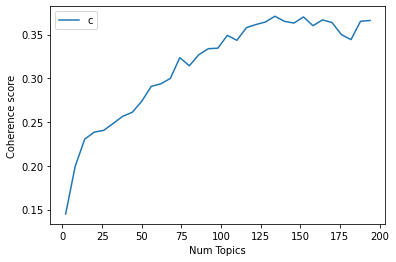

In [46]:
#Plotting graph for number of topics and coherence score
import matplotlib.pyplot as plt
%matplotlib inline

limit=200; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_topic)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [14]:
#Trying for different number of topics

id2word = Dictionary(df_JWC['lemma_tokens_remstop'])

id2word.filter_extremes(no_below=2, no_above=.99)

corpus = [id2word.doc2bow(d) for d in df_JWC['lemma_tokens_remstop']]


base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=5)

words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")
    
#Visualizing topics    
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(base_model, corpus, dictionary=base_model.id2word)
vis

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


------ Topic 0 ------
week infrastructure long resident storm bring miss issue stand talk

------ Topic 1 ------
black help week people tatereeve resident need continue community race

------ Topic 2 ------
resident week storm outage month continue help struggle news fear

------ Topic 3 ------
infrastructure mayor month fix help right like need people amid



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.050582 -0.073478       1        1  28.569991
0     -0.061222 -0.069914       2        1  24.312580
3     -0.080754  0.079402       3        1  23.568596
1      0.091394  0.063990       4        1  23.548832, topic_info=               Term        Freq       Total Category  logprob  loglift
34   infrastructure  275.000000  275.000000  Default  30.0000  30.0000
50             week  395.000000  395.000000  Default  29.0000  29.0000
54            black  173.000000  173.000000  Default  28.0000  28.0000
35             long  125.000000  125.000000  Default  27.0000  27.0000
268       tatereeve  116.000000  116.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
353              go   30.708939  111.028490   Topic4  -5.3102   0.1609
187           thank   25.274532   67.875235   Topic4  -5.5049   0.4582
356            talk   27.848257   96.265337   Topic4  -5.4080   0.2058
239           today   26.683809  104.496119   Topic4  -5.4507   0.0810
786          outage   28.686344  191.608821   Topic4  -5.3783  -0.4529

[305 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
402       1  0.937869            abc
402       2  0.043622            abc
402       3  0.021811            abc
442       3  0.876191     abolishice
840       2  0.910164            add
...     ...       ...            ...
337       3  0.218156           year
337       4  0.264083           year
452       3  0.876193  yemencantwait
854       2  0.255719            yes
854       4  0.703226            yes

[639 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [54]:
pprint(base_model.print_topics())

[(0,
  '0.013*"news" + 0.010*"ongoing" + 0.010*"infrastructure" + 0.010*"mayor" + '
  '0.009*"help" + 0.008*"abc" + 0.007*"national" + 0.007*"time" + '
  '0.006*"thank" + 0.006*"resident"'),
 (1,
  '0.016*"people" + 0.014*"black" + 0.014*"week" + 0.011*"help" + 0.009*"race" '
  '+ 0.009*"legislature" + 0.007*"need" + 0.007*"resident" + 0.007*"hit" + '
  '0.006*"hard"'),
 (2,
  '0.031*"week" + 0.024*"resident" + 0.023*"storm" + 0.016*"outage" + '
  '0.013*"infrastructure" + 0.013*"continue" + 0.013*"month" + '
  '0.011*"struggle" + 0.010*"winter" + 0.010*"miss"'),
 (3,
  '0.014*"help" + 0.013*"infrastructure" + 0.012*"long" + 0.009*"mayor" + '
  '0.008*"break" + 0.008*"month" + 0.008*"racism" + 0.007*"issue" + '
  '0.007*"say" + 0.007*"need"')]


C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(base_model, corpus, dictionary=base_model.id2word)
vis

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.111661  0.056337       1        1  33.557979
3     -0.052136  0.062659       2        1  27.065930
1      0.034664 -0.110450       3        1  21.674038
0     -0.094189 -0.008545       4        1  17.702054, topic_info=             Term        Freq       Total Category  logprob  loglift
49          storm  231.000000  231.000000  Default  30.0000  30.0000
50           week  391.000000  391.000000  Default  29.0000  29.0000
40       struggle  105.000000  105.000000  Default  28.0000  28.0000
1525         fear   75.000000   75.000000  Default  27.0000  27.0000
613   legislature   53.000000   53.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
96       resident   28.701481  308.248035   Topic4  -5.1044  -0.6425
305          know   21.158397   97.436310   Topic4  -5.4093   0.2043
175        ignore   19.496962   69.113235   Topic4  -5.4910   0.4660
35           long   20.686681  128.872207   Topic4  -5.4318  -0.0978
47          right   18.726742   92.617116   Topic4  -5.5314   0.1330

[307 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
403       1  0.174831            abc
403       2  0.021854            abc
403       4  0.808595            abc
444       2  0.852559     abolishice
655       1  0.209620         affect
...     ...       ...            ...
338       4  0.236171           year
454       2  0.852564  yemencantwait
1694      3  0.890938           york
530       1  0.178518           zoom
530       3  0.892588           zoom

[633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [15]:
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, corpus=corpus, texts=df_JWC['lemma_tokens'],
                                   dictionary=id2word, coherence='c_v')
with np.errstate(invalid='ignore'):
    
    coherence_lda_model_base = coherence_model.get_coherence()
    print('\nCoherence Score: ', coherence_lda_model_base)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.21133599440031

Coherence Score:  0.22607526813131423


In [34]:
#7/22
for r in range(10, 51):
    print("Random state",r)
    base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=5, random_state=r)
    words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

    # Create Topics
    topics = [' '.join(t[0:10]) for t in words]

    # Getting the topics
    for id, t in enumerate(topics): 
        print(f"------ Topic {id} ------")
        print(t, end="\n\n")

    #Visualizing topics    
    pyLDAvis.enable_notebook()

    vis = pyLDAvis.gensim_models.prepare(base_model, corpus, dictionary=base_model.id2word)
    vis

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Random state 10
------ Topic 0 ------
resident month black outage infrastructure struggle people fear need bring

------ Topic 1 ------
month help news infrastructure right break outage mayor resident ongoing

------ Topic 2 ------
week storm continue help infrastructure resident miss winter fix people

------ Topic 3 ------
need black mayor get week ignore help today talk people

Random state 11
------ Topic 0 ------
help infrastructure people race black legislature issue mayor know need

------ Topic 1 ------
resident infrastructure outage month struggle fear long black news cause

------ Topic 2 ------
week storm continue help need miss infrastructure resident gop failure

------ Topic 3 ------
week people resident help storm tatereeve outage winter system need

Random state 12
------ Topic 0 ------
infrastructure resident week national go ignore abc black america storm

------ Topic 1 ------
resident outage month struggle fear week news long help know

------ Topic 2 ------
help in

Random state 32
------ Topic 0 ------
help people need infrastructure ongoing know america community texas donate

------ Topic 1 ------
storm week continue infrastructure resident winter black miss news cause

------ Topic 2 ------
week infrastructure mayor resident help racism month long go pandemic

------ Topic 3 ------
outage resident month struggle fear help need day national news

Random state 33
------ Topic 0 ------
resident outage infrastructure black struggle month fear mayor week live

------ Topic 1 ------
week storm continue need miss right gop failure help foxnew

------ Topic 2 ------
help infrastructure people long need racism news national like mayor

------ Topic 3 ------
storm resident winter boil week read ignore help outage notice

Random state 34
------ Topic 0 ------
help people infrastructure right week fix know like today system

------ Topic 1 ------
week people outage boil need infrastructure day notice storm black

------ Topic 2 ------
resident help week m

In [10]:
#For random state 27


id2word = Dictionary(df_JWC['lemma_tokens_remstop'])

id2word.filter_extremes(no_below=2, no_above=.99)

corpus = [id2word.doc2bow(d) for d in df_JWC['lemma_tokens_remstop']]


base_model = LdaMulticore(corpus=corpus, num_topics=4, id2word=id2word, workers=12, passes=5, random_state=27)
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

#Visualizing topics    
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(base_model, corpus, dictionary=base_model.id2word)
vis

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


------ Topic 0 ------
week infrastructure mayor help break month racism pandemic people today

------ Topic 1 ------
tatereeve ignore america infrastructure like flint race talk legislature fix

------ Topic 2 ------
week storm continue resident outage month news struggle miss fear

------ Topic 3 ------
black resident help week need infrastructure people run storm long



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.003615  0.005663       1        1  31.289736
2     -0.083926  0.092985       2        1  26.553478
0     -0.045907 -0.117557       3        1  21.365262
1      0.126219  0.018909       4        1  20.791524, topic_info=           Term        Freq       Total Category  logprob  loglift
325    continue  174.000000  174.000000  Default  30.0000  30.0000
717       break   74.000000   74.000000  Default  29.0000  29.0000
786      outage  188.000000  188.000000  Default  28.0000  28.0000
268   tatereeve  118.000000  118.000000  Default  27.0000  27.0000
1516       fear   76.000000   76.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
16         help   32.087003  276.242150   Topic4  -5.1417  -0.5822
400        news   24.083917  140.041412   Topic4  -5.4286  -0.1898
312    governor   22.480883   82.969837   Topic4  -5.4975   0.2648
96     resident   23.760608  312.780909   Topic4  -5.4422  -1.0068
78         need   22.657807  182.024998   Topic4  -5.4897  -0.5130

[315 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1128      4  0.885424             ab
402       1  0.067285            abc
402       2  0.919564            abc
402       3  0.022428            abc
402       4  0.022428            abc
...     ...       ...            ...
147       1  0.144165           work
147       2  0.240275           work
147       3  0.456522           work
147       4  0.156179           work
452       4  0.851689  yemencantwait

[634 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [11]:
pprint(base_model.print_topics())

[(0,
  '0.018*"week" + 0.014*"infrastructure" + 0.014*"mayor" + 0.013*"help" + '
  '0.012*"break" + 0.010*"month" + 0.009*"racism" + 0.008*"pandemic" + '
  '0.008*"people" + 0.008*"today"'),
 (1,
  '0.013*"tatereeve" + 0.010*"ignore" + 0.010*"america" + '
  '0.008*"infrastructure" + 0.007*"like" + 0.007*"flint" + 0.007*"race" + '
  '0.007*"talk" + 0.006*"legislature" + 0.006*"fix"'),
 (2,
  '0.023*"week" + 0.020*"storm" + 0.018*"continue" + 0.018*"resident" + '
  '0.018*"outage" + 0.014*"month" + 0.013*"news" + 0.011*"struggle" + '
  '0.011*"miss" + 0.010*"fear"'),
 (3,
  '0.016*"black" + 0.015*"resident" + 0.015*"help" + 0.014*"week" + '
  '0.013*"need" + 0.012*"infrastructure" + 0.009*"people" + 0.007*"run" + '
  '0.007*"storm" + 0.006*"long"')]


C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, corpus=corpus, texts=df_JWC['lemma_tokens'],
                                   dictionary=id2word, coherence='c_v')
with np.errstate(invalid='ignore'):
    
    coherence_lda_model_base = coherence_model.get_coherence()
    print('\nCoherence Score: ', coherence_lda_model_base)

C:\Users\rishabhstha\AppData\Local\Programs\Python\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -7.210802425095251

Coherence Score:  0.2572170352827726
